In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import ks_2samp

from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance
from sklearn.linear_model import Ridge, LinearRegression
from sklearn.model_selection import cross_val_score, train_test_split, ShuffleSplit

import skopt

from tspiral.model_selection import TemporalSplit
from tspiral.forecasting import ForecastingCascade, ForecastingChain

In [3]:
### UTILITY FUNCTIONS TO GENERATE SYNTHETIC DATA ###

def gen_sinusoidal(n, amp, freq, noise):
    X = np.arange(n)
    e = np.random.normal(0,noise, n)
    return amp*np.sin(X*(2*np.pi/freq))+e

def gen_randomwalk(n, noise):
    return np.random.normal(0,noise, n).cumsum()

def gen_ts(n, random_state=0):
    np.random.seed(random_state)
    seas1 = gen_sinusoidal(n=n, amp=10, freq=24*4, noise=4)
    seas2 = gen_sinusoidal(n=n, amp=10, freq=24*7*4, noise=4)
    rw = gen_randomwalk(n=n, noise=1)
    X = np.power(np.linspace(0,10, n).reshape(-1,1), [1,2])
    trend = LinearRegression().fit(X, rw).predict(X)
    return seas1 + seas2 + trend
    

n_series, n = 10, 6_000
df = pd.DataFrame(
    {f'ts_{i}': gen_ts(n=n, random_state=i)
     for i in range(n_series)},
    index=pd.date_range('2010-01-01', periods=n, 
                        freq='1h', name='ts')
)  # df.shape: (n_series, n)

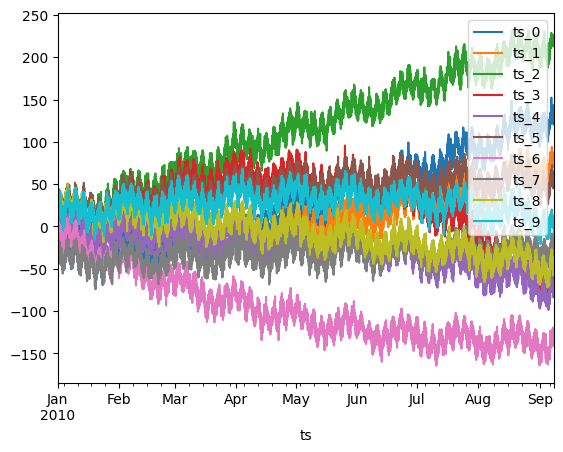

In [4]:
_ = df.plot()

In [5]:
### TRAIN TEST SPLIT AND REARRANGE DATA ###

train, test = train_test_split(df, test_size=24*7, shuffle=False)

train = pd.melt(train, value_vars=df.columns, ignore_index=False,
                var_name='unique_id', value_name='y')

test = pd.melt(test, value_vars=df.columns, ignore_index=False,
                var_name='unique_id', value_name='y')

train['unique_id'] = train['unique_id'].str.replace('ts_','').astype(int)
test['unique_id'] = test['unique_id'].str.replace('ts_','').astype(int)

train.groupby('unique_id').tail(1)

,unique_id,y
ts,,
2010-08-31 23:00:00,0,104.739477
2010-08-31 23:00:00,1,68.398009
2010-08-31 23:00:00,2,188.454744
2010-08-31 23:00:00,3,-81.748381
2010-08-31 23:00:00,4,-87.107538
2010-08-31 23:00:00,5,30.775797
2010-08-31 23:00:00,6,-158.752245
2010-08-31 23:00:00,7,-49.775723
2010-08-31 23:00:00,8,-61.454939


## FIT

In [6]:
### INITIALIZE A FORECASTING MODEL INSTANCE ###

forecaster = ForecastingCascade(
    Ridge(),
    lags=range(1,24*7+1),
    groups=[0],
    target_diff=True,
)

In [7]:
### FIT ###

forecaster.fit(X=train[['unique_id']], y=train['y'])

ForecastingCascade(estimator=Ridge(), groups=[0], lags=range(1, 169),
                   target_diff=True)

In [8]:
### SAVE AND LOAD A FITTED MODEL INSTANCE ###

import pickle

# save
pickle.dump(forecaster, open('model.pkl','wb'))

# load
forecaster = pickle.load(open('model.pkl','rb'))

In [9]:
### PARALLEL MODELS FIT FOR EACH TIME SERIES ###

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

models = train.groupby('unique_id').parallel_apply(
    lambda x: forecaster.fit(X=x[['unique_id']], y=x['y'])
)

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


## INFERENCE

In [10]:
### FORECASTING ###

preds = forecaster.predict(X=test[['unique_id']])

In [11]:
### PARALLEL MODELS FORECASTING FOR EACH TIME SERIES ###

from pandarallel import pandarallel
pandarallel.initialize(progress_bar=True)

preds = train.groupby('unique_id').parallel_apply(
    lambda x: forecaster.fit(
        X=x[['unique_id']], y=x['y']
    ).predict(
        X=pd.DataFrame({
            'unique_id': np.full((24*7,), x['unique_id'].iloc[0])
        })
    )
).explode().to_frame('pred').reset_index()

INFO: Pandarallel will run on 2 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [12]:
### FORECASTING PASSING NEW DATA ###

preds = forecaster.predict(
    X=pd.DataFrame({'unique_id': 
                    np.repeat(train['unique_id'].unique(), 24*7)}),
    last_y=train.groupby('unique_id')['y'].head(24*8),
    last_X=train.groupby('unique_id')[['unique_id']].head(24*8)
)

## EVALUATION

In [13]:
### CROSS-VALITION SCORING ###

cv_scores = cross_val_score(
    forecaster,
    X=train[['unique_id']], y=train['y'],
    groups=train[['unique_id']],
    cv=TemporalSplit(n_splits=5, test_size=24*2, gap=24*2),
    scoring='neg_mean_squared_error', error_score='raise',
)

cv_scores

array([-38.29185546, -38.06164873, -36.33975979, -39.41807432,
       -34.08109687])

## PARAMETER TUNING

In [14]:
### BAYESIAN PARAMETER TUNING ###

model = skopt.BayesSearchCV( 
    forecaster,
    search_spaces={
        'estimator__alpha': skopt.space.Real(1,20, prior='log-uniform'),
    },
    cv=TemporalSplit(n_splits=3, test_size=24*2, gap=24*2),
    scoring='neg_mean_squared_error', error_score='raise',
    n_iter=15, random_state=42, refit=True,
).fit(train[['unique_id']], train['y'], groups=train[['unique_id']])

model.best_score_, model.best_params_

(-36.612980016769626, OrderedDict([('estimator__alpha', 1.0109347810455676)]))

## FEATURE SELECTION

In [15]:
### FEATURE SELECTION WITH RECURSIVE STRATEGY ###

forecaster = ForecastingCascade(
    RFECV(
        Ridge(),
        cv=ShuffleSplit(1, test_size=0.25),
        scoring='neg_mean_squared_error',
    ),
    lags=range(1,24*7+1),
    groups=[0],
    target_diff=True,
).fit(train[['unique_id']], train['y'])


feature_ranking = pd.DataFrame({
    'feature': forecaster.feature_names_,
    'ranking': forecaster.estimator_.ranking_,
}).sort_values(by='ranking')

## EXPLAINABILITY

In [16]:
### TRAINING WITH PERMUTATION IMPORTANCE ###

class ExplainerRegressor(Ridge):
    def fit(self, X,y):
        id_train, id_val = train_test_split(
            np.arange(X.shape[0]), random_state=42,
        )
        super().fit(X[id_train], y[id_train])
        
        self.perm_feature_importance_ = permutation_importance(
            self, X[id_val], y[id_val], 
            n_repeats=5, random_state=42,
        )['importances_mean']
        
        return super().fit(X, y)
    
forecaster = ForecastingCascade(
    ExplainerRegressor(),
    lags=range(1,24*7+1),
    groups=[0],
    target_diff=True,
).fit(train[['unique_id']], train['y'])


feature_importance = pd.DataFrame({
    'feature': forecaster.feature_names_,
    'importance': forecaster.estimator_.perm_feature_importance_,
}).sort_values(by='importance')

## PERFORMANCE DRIFT

In [17]:
### SEARCHING FOR PERFORMCE DRIFTS ###

CV = TemporalSplit(n_splits=20, test_size=24, gap=24)
stream_simulator = CV.split(train, groups=train['unique_id'])

scores_valid, scores_test = [], []
for i, (id_past, id_future) in enumerate(stream_simulator):
    if i < 1:
        forecaster.fit(
            X=train[['unique_id']].iloc[id_past], 
            y=train['y'].iloc[id_past]
        )
    score = forecaster.score(
        X=train[['unique_id']].iloc[id_future], 
        y=train['y'].iloc[id_future],
        last_X=train[['unique_id']].iloc[id_past],
        last_y=train['y'].iloc[id_past],
        scoring='mse'
    )
    if i < CV.get_n_splits() //2:
        scores_valid.append(score)
    else:
        scores_test.append(score)
        
        
ks_2samp(scores_valid, scores_test)

KstestResult(statistic=0.4, pvalue=0.41752365281777043, statistic_location=33.499850949938875, statistic_sign=1)